In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob as glob
import pickle 
import os
from IPython.display import clear_output

/home/pukkasahib/.venvs/mdanalysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The protein data bank (PDB) provides us with approximately 73 structures of the A2A protein. How can we use this experimental information to inform our understanding of the dynamics of A2A?

The structures within the PDB are resolved using a few key structural biology methods that include:
- X-ray crystallography (one of the msot commonly used)
- Cryo-electron microscopy
- Microcrystal electron diffraction.

Preparing a protein for crystallization, the crystallization process, and then determining the 3D structure of the protein is a challenging process that can take years. To help stabilize the protein when preparing it for an experiment, a small molecule ligand will be associated with the protein, such as an agonist or an antagonist. As of today, there are 73 crystal structures of the A2A protein in the PDB, with approximately 10 of them representing the activated form of A2A and the remainder representing the inactivated form.

**Question:** With this large amount of structural data, can we use it to interrogate the dynamics of A2A, and make use of our simulations to fill in the gaps?

In [2]:
def clustalMSApreparation(inputDirectory_crystals, atomSelection, outputDirectory_clustalPrep):
    
    """
    Function that takes as input a set of crystal structures and outputs a clustal omega compatible .txt file
    that can be fed into clustal omega multiple-sequence alignment web server.    
    """
    
    ## function from MDAnalysis to give the sequence of proteins in terms of single letter representations.

    def getModelledSeq(pdb_structure):
        """
        Goal: function that spits out the input-sequence in their single-letter representation
        """
        mystr = "" # linebreaks and arrow ('>') for clustal to recognize new sequences
        for i in range(len(pdb_structure.residues.resids)):
            # mdanalysis utility to convert the sequence into their 1-letter assignments
            mystr += mda.lib.util.convert_aa_code(pdb_structure.residues.resnames[i])
        return mystr

    ## (1) start by adding the crystal structures and the starting structure to a list

    # directory with PDB structures
    directory = inputDirectory_crystals

    ## creating list to hold universes of all crystal structures and our starting structure

    # we start by adding all of the crystal structures
    crystal_unis = []
    for filename in os.listdir(directory):
        crystal_unis.append(mda.Universe(directory + str(filename)))

    ## (2) We create a list of the single-letter residues for all of the crystal structures

    # contains all of the modelled residues for each construct
    # this picks out the residues that are actually modelled in the crystal structures
    crystal_modelled_residues = []

    for i,file in enumerate(os.listdir(directory)):
        # from the file name we pick out the PDB ID (file[3:7])
        # we have a convoluted atom selection syntax to pick residues that are modelled on a single chain without duplicates
        temp_sequence = "\n>" + file[0:4] + '\n' + getModelledSeq(mda.Universe(directory + str(file)).select_atoms(atomSelection))
        crystal_modelled_residues.append(temp_sequence)

    ## (3) This is to organize the strings that will be fed into clustal.

    # append each construct's sequence to a textfile for input into clustal (https://www.ebi.ac.uk/Tools/msa/clustalo/)
    clustal_input = ([crystal_modelled_residues[j] for j in range(len(crystal_modelled_residues))])
    with open(outputDirectory_clustalPrep, 'w') as clustal_writer:
        for n in range(len(crystal_modelled_residues)):
            clustal_writer.write(clustal_input[n])
    clustal_writer.close()
    
    return "Job completed: check for input.txt file in {}".format(outputDirectory_clustalPrep)

In [4]:
%%time

## perform the msa preparation on the a2a crystals

from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

## call our function and save the output file.
clustalMSApreparation('./data/a2a_pdbs/',
                     'protein and backbone and name CA and segindex 0 and not altLoc B',
                     f'./data/clustalInput_{date}.txt')

CPU times: user 4.45 s, sys: 92.1 ms, total: 4.54 s
Wall time: 4.55 s


'Job completed: check for input.txt file in ./data/clustalInput_2025-06-15.txt'

# We would then use clustalOmega to perform the multiple sequence alignment.
- We can use the online web-server.
- We will receive an output file that has the alignment. We can examine what it looks like in our data folder and understand how it aligned the sequences of all of the crystal structures.
- Note that we're doing an MSA on a singl eprotein, but with different numbers of residues because of different preparation methods. We are not using MSA to identify co-evolving residue, as is usually the case when applying MSA!

# We then use this output from clustalOmega's MSA to construct the set of topologically equivalent residues for our structures.


### Create the atom_selection strings for each crystal structure's 'topologically equivalent' residues, with reference to the multiple sequence alignment
- We will then append each selection string to the corresponding entry in the crystal structure dictionary. This will streamline our work, for example when computing PCA.
- This requires a clustalOmega MSA input.
- !! clustal omega outputs a file that has a line structure as: 'pdbid \n sequence'.
    - Therefore, we include in the script a way to take the pdbid and the corresponding msa. This way we don't need to manually manipulate the files.

In [5]:
## (1) Start by identifying the directory that houses the aligned crystal structures.

# directory with aligned PDB structures
directory = './data/a2a_pdbs/'
a2a_structure_names = ['2ydo', '5g53', '5iua', '2ydv', '4uhr', '5wf5', '5wf6', '6gdg', '4eiy', '5k2a', '3rey', '5iu7', '5k2d', '5mzp']

## creating list to hold universes of all crystal structures
crystal_unis = [mda.Universe(directory + pdbID + '.pdb') for pdbID in a2a_structure_names]

## (2) Use the MSA output to create the appropriate selection strings for all crystals

# open the clustal file
clustal_output_directory = './data/clustalOutput_14structures.txt'
clustal_output           = open(clustal_output_directory)

alignment_list = [] # append .txt lines to a list
pdbids_list    = [] # append matching pdb ids to list

# identify number of lines by looping
with open(clustal_output_directory, 'r') as file:
    total_lines = sum(1 for _ in file)
    
# now loop through again and store the pdbs and their sequences alignment strings.
for linenum,line in enumerate(clustal_output, start=0):
    if linenum != total_lines and linenum % 2 != 0: # odd lines are sequences
        alignment_list.append(line[:-1])            # append sequence
    elif linenum == total_lines:
        alignment_list.append(line)                 # for the final line, include last element
    elif linenum % 2 == 0:                          # append pdb id for even lines
        pdbids_list.append(line[1:5])               # exclude '>' character and line break
clustal_output.close()                              # close the file

## (3) convert the list to a binary matrix

### FIRST WE CONVER THE LIST OF ALIGNMENT SEQUENCES INTO AN ARRAY OF 14X476, each col is an individual sequence element 
# list of alignment strings
list_of_strings = alignment_list
# Convert each string to a list of characters
chars_lists = [list(s) for s in list_of_strings]
# Determine the maximum length of the strings to pad shorter strings
max_length = max(len(s) for s in list_of_strings)
# Pad shorter strings with spaces to make all arrays of equal length
chars_lists_padded = [s + [' '] * (max_length - len(s)) for s in chars_lists]
# Convert the list of lists of characters to a NumPy array
array_2d = np.array(chars_lists_padded)

# create an empty array to hold the lines (n_rows x n_cols)
alignment_array = np.zeros(array_2d.shape)
alignment_array  = np.array([[1 if char.isalpha() else 0 for char in sublist] for sublist in array_2d]
                           )

## here we create the binary array for all constructs, and where we append the corresponding resid for each structure if all 
## structures at this position have a residue present (i.e. topologically equivalent residues)

# list to hold the aligned resids for each crystal.
listofresidues = [[] for _ in range(len(alignment_list))] # to contain all of the construct IDs

# looping over each construct we determine which constructs share a residue in the position
# then we append the resid unique to the current crystal to the listofresidues for each crystal

nrows = array_2d.shape[0] # number of crystals
ncols = array_2d.shape[1] # number of total residues in MSA

for j in range(nrows):                      # loop over constructs
    
    print('Working on construct', j+1,'of {}.'.format(nrows), end='\r')
    
    # reset the counter for each crystal
    counter = -1                                          # counter; first hit of '1' gives resindex 0
    for i in range(ncols):               # total no. of cols from MSA output
        if alignment_array[j][i] == 1:                    # if element has a residue
            counter += 1                                  # +1 when hit a residue (resindex, not resid)
            
            if np.all(alignment_array.T[i] == 1):         # iff col has all '1's (i.e. all crystals have a res here)
                listofresidues[j].append(crystal_unis[j].residues[counter].resid) # append j-th crystal resid based on the resindex (!! NOT resnum !!)
            else:
                continue
        else:
            continue

## (4) create unique atom_selections for each of the crystals
selectionstring_holder           = [] # holder for selection strings of each uni
crystals_with_selections_calphas = [] # pdb_unis with calpha selections -- to verify lengths
crystals_with_selections_full    = [] # pdb_unis with full selections -- for visualization

for k in range(len(listofresidues)): # loop over crystal structures
    
    selection_string = ''
    for i in range(len(listofresidues[k])):                             # num of common resids across structures
        
        selection_string += 'resid {} or '.format(listofresidues[k][i]) # k-th crystal, i-th resindex
        
    # we append the selection string & the filename, to use as an index
    selectionstring_holder.append(selection_string)
    # save the calpha representations of alignment
    crystals_with_selections_calphas.append(crystal_unis[k].select_atoms('{}'.format('protein and backbone and name CA and segindex 0 and not altLoc B and (' + selectionstring_holder[k][:-4] + ')')
                                                                 )      # exclude altlocB since some residues will double count!
                                        )                               # final selection string -- omit " or " -- AND don't forget parenthese around "resid or..."
    # save the all-atom representation of alignment
    crystals_with_selections_full.append(crystal_unis[k].select_atoms('{}'.format('protein and segindex 0 and not altLoc B and (' + selectionstring_holder[k][:-4] + ')')
                                                                 )      # exclude altlocB since some residues will double count!
                                        )
# save the selection string holder
np.save('./data/msa_selectionStringHolder.npy', selectionstring_holder, allow_pickle=True)
print('Note that the order of structures matches between the pdbids_list and the crystal directory:')

# check that the order is preserved from crystal unis directory and the msa sequence processing.
gg = []
for i in a2a_structure_names:
    gg.append(i[:4])
gg == pdbids_list

Note that the order of structures matches between the pdbids_list and the crystal directory:


True

# We can visualize what the alignment of the topologically equivalent residues across all of the 14 crystal structures looks like.
- We see that the black squares indicates residues that are present across all of the structures -- these are the residues that are chosen in our selection.
- Spaces of white indicate residue positions where there are no topologically equivalent residues (i.e. these are the gaps in the multiple sequence alignment)

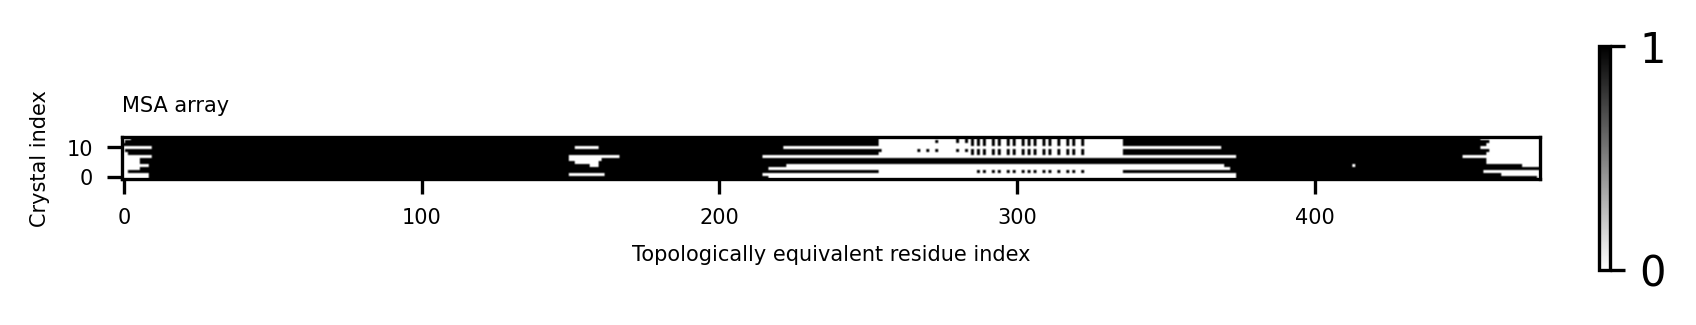

In [17]:
plt.figure(dpi = 300)
plt.title('MSA array', fontsize=5, loc='left')
plt.xlabel('Topologically equivalent residue index', fontsize=5)
plt.ylabel('Crystal index', fontsize=5)
plt.imshow(alignment_array, origin='lower', cmap = 'binary', interpolation=None)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
cbar = plt.colorbar(fraction=0.0075, pad=0.04,)
cbar.set_ticks(range(2))
plt.show()

In [7]:
## Let's check that we have universes with the same number of residues

# looping through each universe, let's print out how many residues exist. They should all be the same number!
for universe in (crystals_with_selections_calphas):
    print(universe.residues.n_residues)

# let's also save these universes a dictionary
a2a_dictionary = dict(zip(pdbids_list, crystals_with_selections_calphas))
# print the dictionary to see what it looks like
print(a2a_dictionary)

# save the dictionary as a pickled object
with open('./data/a2a_dictionary.pkl', 'wb') as ff:
    pickle.dump(a2a_dictionary, ff)

263
263
263
263
263
263
263
263
263
263
263
263
263
263
{'2ydo': <AtomGroup with 263 atoms>, '5g53': <AtomGroup with 263 atoms>, '5iua': <AtomGroup with 263 atoms>, '2ydv': <AtomGroup with 263 atoms>, '4uhr': <AtomGroup with 263 atoms>, '5wf5': <AtomGroup with 263 atoms>, '5wf6': <AtomGroup with 263 atoms>, '6gdg': <AtomGroup with 263 atoms>, '4eiy': <AtomGroup with 263 atoms>, '5k2a': <AtomGroup with 263 atoms>, '3rey': <AtomGroup with 263 atoms>, '5iu7': <AtomGroup with 263 atoms>, '5k2d': <AtomGroup with 263 atoms>, '5mzp': <AtomGroup with 263 atoms>}


/tmp/ipykernel_12860/3198989149.py:14: UserWarning: Reader has no dt information, set to 1.0 ps
  pickle.dump(a2a_dictionary, ff)
